# CLASSIFICATION D'IMAGES D'INCENDIES AVEC RÉSEAUX DE NEURONES

**Nom :** BOUEDO  
**Prénom :** THEO  
**Date :** 08/12/2023

# I. Importation des library

In [240]:
from datasets import load_dataset
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch
import os
from concurrent.futures import ThreadPoolExecutor

# II. Gestion & analyse des images

## A. Analyse de la base initiale

In [1]:
dataset = load_dataset("pyronear/openfire")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image_url', 'is_wildfire'],
        num_rows: 7143
    })
    validation: Dataset({
        features: ['image_url', 'is_wildfire'],
        num_rows: 792
    })
})


In [167]:
def calculate_counts_and_proportions(dataset_split):
    wildfire_images = [item for item in dataset_split if item['is_wildfire']]
    non_wildfire_images = [item for item in dataset_split if not item['is_wildfire']]

    count_wildfire = len(wildfire_images)
    count_non_wildfire = len(non_wildfire_images)
    total_images = count_wildfire + count_non_wildfire

    proportion_wildfire = round((count_wildfire / total_images) * 100, 2)
    proportion_non_wildfire = round((count_non_wildfire / total_images) * 100, 2)

    return count_wildfire, count_non_wildfire, total_images, proportion_wildfire, proportion_non_wildfire

# Calcul pour l'ensemble d'entraînement et de validation
train_counts = calculate_counts_and_proportions(dataset['train'])
val_counts = calculate_counts_and_proportions(dataset['validation'])

# Affichage du tableau
table_data = {
    "Dataset": ["Train", "Validation"],
    "Incendie": [train_counts[0], val_counts[0]],
    "Non-Incendie": [train_counts[1], val_counts[1]],
    "Total": [train_counts[2], val_counts[2]],
    "% Incendie": [train_counts[3], val_counts[3]],
    "% Non-Incendie": [train_counts[4], val_counts[4]]
}

for key, values in table_data.items():
    print(f"{key:<15} {' | '.join(str(value) for value in values)}")

Dataset         Train | Validation
Incendie        2518 | 279
Non-Incendie    4625 | 513
Total           7143 | 792
% Incendie      35.25 | 35.23
% Non-Incendie  64.75 | 64.77


## B. Téléchargement des images

Niveau temps, cela m'a pris entre 1 et 2h avec une connexion fibré 

In [ ]:
# Paramètre de configuration
BASE_DIR = 'C:/Users/theob/Desktop/M2/svm/projet'
NUM_THREADS = 10  # Vous pouvez augmenter ce nombre si votre connexion le permet

# Fonction pour télécharger une image
def download_image(url, target_path):
    try:
        # Nettoyer l'URL pour supprimer les paramètres après l'extension de fichier
        clean_url = url.split('?')[0]  
        response = requests.get(clean_url, stream=True)
        if response.status_code == 200:
            os.makedirs(os.path.dirname(target_path), exist_ok=True)
            # Assurez-vous que le chemin cible ne contient pas de caractères invalides
            clean_target_path = target_path.split('?')[0]
            with open(clean_target_path, 'wb') as f:
                f.write(response.content)
            print(f"Image téléchargée : {clean_target_path}")
    except Exception as e:
        print(f"Erreur lors du téléchargement de {url}: {e}")

# Fonction pour organiser et télécharger les images
def organise_and_download(dataset, base_folder, subset_name):
    for label in ['avec_incendie', 'sans_incendie']:
        label_bool = (label == 'avec_incendie')  # True pour 'avec_incendie', False pour 'sans_incendie'
        images = [(item['image_url'], item['is_wildfire']) for item in dataset if item['is_wildfire'] == label_bool]
        target_label_folder = os.path.join(base_folder, subset_name, label)
        os.makedirs(target_label_folder, exist_ok=True)  # Créer le dossier s'il n'existe pas

        for image_url, is_wildfire in images:
            file_name = image_url.split('/')[-1].split('?')[0]  # Nettoyer le nom du fichier
            target_path = os.path.join(target_label_folder, file_name)
            download_image(image_url, target_path)

# Chargement du jeu de données
dataset = load_dataset("pyronear/openfire")

# Téléchargement des images avec ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
    # Création des dossiers s'ils n'existent pas
    for subset_name in ['train', 'validation']:
        for category in ['avec_incendie', 'sans_incendie']:
            os.makedirs(os.path.join(BASE_DIR, subset_name, category), exist_ok=True)
    
    # Téléchargement pour l'ensemble d'entraînement et de validation
    executor.submit(organise_and_download, dataset['train'], BASE_DIR, 'train')
    executor.submit(organise_and_download, dataset['validation'], BASE_DIR, 'validation')

print("Téléchargement des images terminé.")

## C. Supprimer les images corrompues

In [161]:
def delete_corrupted_images(folder_path):
    corrupted_files = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img = Image.open(os.path.join(root, file))  # Tenter d'ouvrir l'image
                    img.verify()  # Vérifier l'intégrité
                except (IOError, SyntaxError) as e:
                    corrupted_file_path = os.path.join(root, file)
                    print(f'Suppression du fichier corrompu : {corrupted_file_path}')
                    os.remove(corrupted_file_path)  # Supprimer le fichier corrompu
                    corrupted_files += 1
    print(f"Nombre total de fichiers corrompus supprimés : {corrupted_files}")

# Appliquer la suppression sur vos dossiers d'images
delete_corrupted_images('train/')
delete_corrupted_images('validation/')

C:\Users\theob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Nombre total de fichiers corrompus supprimés : 0
Nombre total de fichiers corrompus supprimés : 0


## D. Base finale

In [239]:
def count_images_and_calculate_proportions(directory):
    total_images = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
    return total_images

# Chemin de base
BASE_DIR = 'C:/Users/theob/Desktop/M2/svm/projet'

# Chemins pour chaque catégorie
paths = {
    'Train avec Incendie': os.path.join(BASE_DIR, 'train/avec_incendie'),
    'Train sans Incendie': os.path.join(BASE_DIR, 'train/sans_incendie'),
    'Validation avec Incendie': os.path.join(BASE_DIR, 'validation/avec_incendie'),
    'Validation sans Incendie': os.path.join(BASE_DIR, 'validation/sans_incendie')
}

# Compter les images et calculer les proportions
counts = {category: count_images_and_calculate_proportions(path) for category, path in paths.items()}
total_train_images = counts['Train avec Incendie'] + counts['Train sans Incendie']
total_validation_images = counts['Validation avec Incendie'] + counts['Validation sans Incendie']

# Affichage du tableau
table_data = {
    "Dataset": ["Train", "Validation"],
    "Avec Incendie": [counts['Train avec Incendie'], counts['Validation avec Incendie']],
    "Sans Incendie": [counts['Train sans Incendie'], counts['Validation sans Incendie']],
    "Total": [total_train_images, total_validation_images],
    "% Avec Incendie": [round((counts['Train avec Incendie'] / total_train_images) * 100, 2),
                        round((counts['Validation avec Incendie'] / total_validation_images) * 100, 2)],
    "% Sans Incendie": [round((counts['Train sans Incendie'] / total_train_images) * 100, 2),
                         round((counts['Validation sans Incendie'] / total_validation_images) * 100, 2)]
}

for key, values in table_data.items():
    print(f"{key:<20} {' | '.join(str(value) for value in values)}")


Dataset              Train | Validation
Avec Incendie        1981 | 229
Sans Incendie        3444 | 425
Total                5425 | 654
% Avec Incendie      36.52 | 35.02
% Sans Incendie      63.48 | 64.98


# III. Optimisation et Évaluation de Modèles 

## A. Modèle CNN

### i. Prétraitement

Found 4844 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


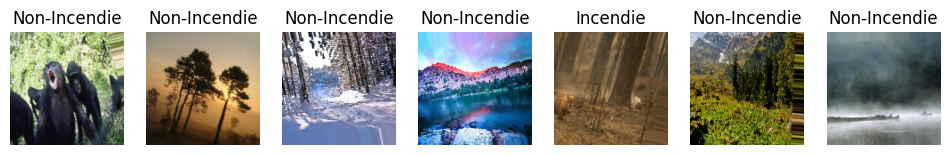

In [215]:
# Configuration du générateur de données d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rééchelonne les valeurs des pixels pour être entre 0 et 1
    rotation_range=20,  # Rotation aléatoire des images dans la plage de 20 degrés
    width_shift_range=0.1,  # Décalage horizontal des images jusqu'à 10% de leur largeur
    height_shift_range=0.1,  # Décalage vertical des images jusqu'à 10% de leur hauteur
    shear_range=0.2,  # Applique une transformation de cisaillement jusqu'à 20%
    zoom_range=0.2,  # Zoom aléatoire des images jusqu'à 20%
    horizontal_flip=True,  # Retournement horizontal aléatoire des images
    fill_mode='nearest'  # Stratégie de remplissage des pixels nouvellement créés
)

# Création du générateur pour l'ensemble d'entraînement
train_generator = train_datagen.flow_from_directory(
    'train/',  
    target_size=(128, 128),  # Redimensionne les images à 128x128 pixels
    batch_size=32,  # Taille de lot pour l'entraînement
    class_mode='binary'  # Mode binaire pour la classification (2 classes)
)

# Configuration du générateur de données de validation (sans augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    'validation/', 
    target_size=(128, 128),  # Redimensionne les images à 128x128 pixels
    batch_size=32,  # Taille de lot pour la validation
    class_mode='binary'  # Mode binaire pour la classification
)

# Chargement d'un lot d'images et de labels de l'ensemble d'entraînement
images, labels = next(train_generator)

# Affichage des 7 premières images avec leurs étiquettes
plt.figure(figsize=(12, 6))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(images[i])
    plt.title('Non-Incendie' if labels[i] else 'Incendie')
    plt.axis('off')
plt.show()

### ii. Construction et Entraînement 

In [216]:
# Définition du modèle séquentiel
model = Sequential([
    # Première couche de convolution avec 16 filtres, taille de filtre 3x3, activation ReLU
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    # Première couche de max pooling avec une fenêtre de 2x2
    MaxPooling2D(2, 2),
    
    # Deuxième couche de convolution avec 32 filtres
    Conv2D(32, (3, 3), activation='relu'),
    # Deuxième couche de max pooling
    MaxPooling2D(2, 2),
    
    # Troisième couche de convolution avec 64 filtres
    Conv2D(64, (3, 3), activation='relu'),
    # Troisième couche de max pooling
    MaxPooling2D(2, 2),

    # Aplatir les données pour les rendre compatibles avec les couches denses
    Flatten(),

    # Couche dense avec 64 unités et activation ReLU
    Dense(64, activation='relu'),
    # Couche de sortie avec activation sigmoïde pour la classification binaire
    Dense(1, activation='sigmoid')
])

# Compilation du modèle avec l'optimiseur Adam, perte de crossentropie binaire et suivi de la précision
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec le générateur d'entraînement, sur 10 époques et validation avec le générateur de validation
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator)

Epoch 1/10
125/152 [=======================>......] - ETA: 44s - loss: 0.5184 - accuracy: 0.7314

C:\Users\theob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


152/152 [==============================] - 275s 2s/step - loss: 0.5080 - accuracy: 0.7343 - val_loss: 0.5560 - val_accuracy: 0.7380
Epoch 2/10
152/152 [==============================] - 260s 2s/step - loss: 0.4627 - accuracy: 0.7622 - val_loss: 0.5285 - val_accuracy: 0.7344
Epoch 3/10
152/152 [==============================] - 255s 2s/step - loss: 0.4382 - accuracy: 0.7750 - val_loss: 0.5069 - val_accuracy: 0.7504
Epoch 4/10
152/152 [==============================] - 2949s 20s/step - loss: 0.4232 - accuracy: 0.7917 - val_loss: 0.4575 - val_accuracy: 0.7611
Epoch 5/10
152/152 [==============================] - 197s 1s/step - loss: 0.4111 - accuracy: 0.8031 - val_loss: 0.4801 - val_accuracy: 0.7790
Epoch 6/10
152/152 [==============================] - 194s 1s/step - loss: 0.3955 - accuracy: 0.8095 - val_loss: 0.6908 - val_accuracy: 0.7219
Epoch 7/10
152/152 [==============================] - 2246s 15s/step - loss: 0.3853 - accuracy: 0.8148 - val_loss: 0.4710 - val_accuracy: 0.7986
Epoch 

In [217]:
model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 64)       

### iii. Analyse 

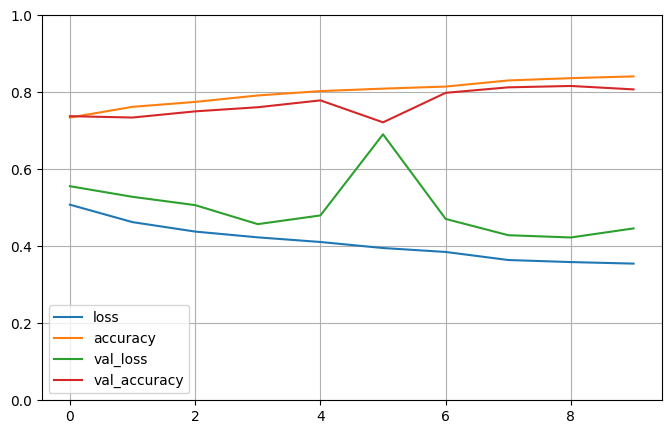

In [219]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()  

## B. Modèle CNN avec CLAHE

### i. Prétraitement

Found 4844 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


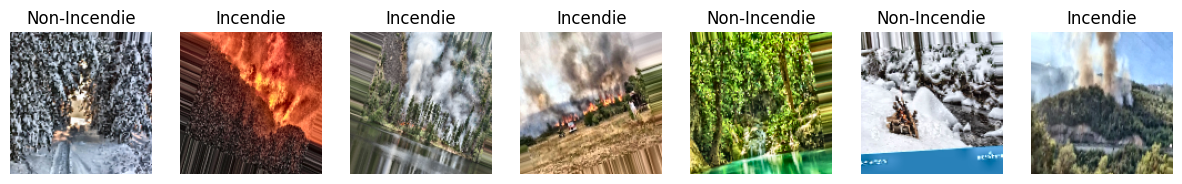

In [241]:
def preprocess_with_clahe(img):
    # Vérification du type de données de l'image et conversion en uint8 si nécessaire
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Conversion de l'image en espace colorimétrique LAB pour l'application de CLAHE
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)

    # Création de l'objet CLAHE et application sur le canal L
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(12, 12))
    l_clahe = clahe.apply(l)

    # Fusion des canaux modifiés et reconversion en RGB
    img_lab_clahe = cv2.merge([l_clahe, a, b])
    img_rgb_clahe = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2RGB)

    # Normalisation des valeurs de pixel après traitement CLAHE
    img_rescaled = img_rgb_clahe / 255.0

    return img_rescaled

# Configuration de ImageDataGenerator pour l'entraînement avec fonction de prétraitement personnalisée
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_with_clahe,  # Application de CLAHE pour l'amélioration du contraste
    rotation_range=20,  # Rotation aléatoire des images jusqu'à 20 degrés
    width_shift_range=0.1,  # Décalage horizontal des images jusqu'à 10% de leur largeur
    height_shift_range=0.1,  # Décalage vertical des images jusqu'à 10% de leur hauteur
    shear_range=0.2,  # Cisaillement des images jusqu'à 20%
    zoom_range=0.2,  # Zoom aléatoire jusqu'à 20%
    horizontal_flip=True,  # Retournement horizontal aléatoire
    fill_mode='nearest'  # Stratégie de remplissage des zones nouvellement créées
)

# Configuration similaire pour l'ensemble de validation sans augmentation
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_with_clahe)

# Création du générateur d'entraînement
train_generator_clahe = train_datagen.flow_from_directory(
    'train/',  
    target_size=(128, 128),  # Taille cible des images
    batch_size=32,  # Taille des lots d'images
    class_mode='binary'  # Mode binaire pour la classification
)

# Création du générateur de validation
validation_generator = validation_datagen.flow_from_directory(
    'validation/', 
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Chargement d'un lot d'images et de labels de l'ensemble d'entraînement
images, labels = next(train_generator_clahe)

# Affichage des 7 premières images avec étiquetage
plt.figure(figsize=(15, 6))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(images[i])
    plt.title('Non-Incendie' if labels[i] else 'Incendie')
    plt.axis('off')
plt.show()

### ii. Construction et Entraînement

In [226]:
# Définition du modèle séquentiel
model = Sequential([
    # Première couche de convolution : 16 filtres de taille 3x3, activation ReLU
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    # Première couche de MaxPooling : réduction de la dimension spatiale
    MaxPooling2D(2, 2),

    # Deuxième couche de convolution : 32 filtres de taille 3x3, activation ReLU
    Conv2D(32, (3, 3), activation='relu'),
    # Deuxième couche de MaxPooling
    MaxPooling2D(2, 2),

    # Troisième couche de convolution : 64 filtres de taille 3x3, activation ReLU
    Conv2D(64, (3, 3), activation='relu'),
    # Troisième couche de MaxPooling
    MaxPooling2D(2, 2),

    # Aplatir les données pour les couches denses
    Flatten(),

    # Couche dense intermédiaire : 64 neurones, activation ReLU
    Dense(64, activation='relu'),
    # Couche de sortie : 1 neurone, activation sigmoid pour classification binaire
    Dense(1, activation='sigmoid')
])

# Compilation du modèle avec des paramètres spécifiques
model.compile(
    optimizer='adam',  # Optimiseur Adam
    loss='binary_crossentropy',  # Perte de crossentropie binaire pour classification binaire
    metrics=['accuracy']  # Suivi de la précision comme métrique
)

# Entraînement du modèle
history = model.fit(
    train_generator_clahe,  # Utilisation du générateur avec CLAHE
    epochs=10,  # Nombre d'itérations sur l'ensemble des données
    validation_data=validation_generator  # Données de validation pour évaluer le modèle
)

Epoch 1/10
121/152 [======================>.......] - ETA: 49s - loss: 0.5421 - accuracy: 0.7069

C:\Users\theob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


152/152 [==============================] - 266s 2s/step - loss: 0.5292 - accuracy: 0.7174 - val_loss: 0.6442 - val_accuracy: 0.6898
Epoch 2/10
152/152 [==============================] - 289s 2s/step - loss: 0.4726 - accuracy: 0.7483 - val_loss: 0.5407 - val_accuracy: 0.7219
Epoch 3/10
152/152 [==============================] - 328s 2s/step - loss: 0.4611 - accuracy: 0.7640 - val_loss: 0.5231 - val_accuracy: 0.7273
Epoch 4/10
152/152 [==============================] - 326s 2s/step - loss: 0.4457 - accuracy: 0.7737 - val_loss: 0.6234 - val_accuracy: 0.7237
Epoch 5/10
152/152 [==============================] - 280s 2s/step - loss: 0.4365 - accuracy: 0.7845 - val_loss: 0.5047 - val_accuracy: 0.7487
Epoch 6/10
152/152 [==============================] - 252s 2s/step - loss: 0.4223 - accuracy: 0.7925 - val_loss: 0.4779 - val_accuracy: 0.7647
Epoch 7/10
152/152 [==============================] - 268s 2s/step - loss: 0.4103 - accuracy: 0.7977 - val_loss: 0.4937 - val_accuracy: 0.7558
Epoch 8/10

In [227]:
model.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 64)       

### iii. Analyse

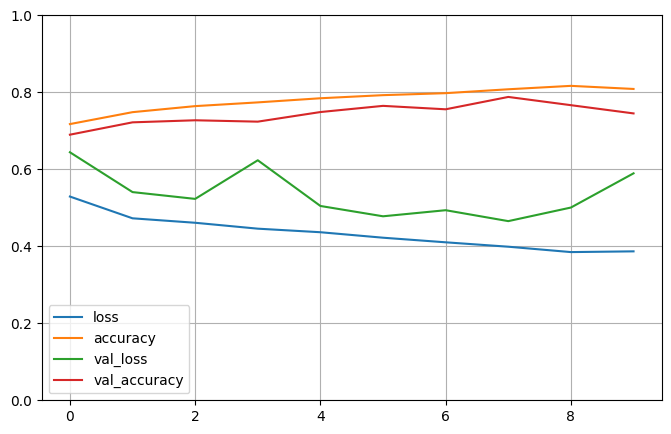

In [228]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

## C. Modèle CNN avec transfert d'apprentissage

### i. Construction et Entrainement

In [229]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Congeler les couches du modèle pré-entraîné

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator)

Epoch 1/10
 29/152 [====>.........................] - ETA: 3:05 - loss: 0.3828 - accuracy: 0.8179

C:\Users\theob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


152/152 [==============================] - 234s 2s/step - loss: 0.3758 - accuracy: 0.8237 - val_loss: 0.6046 - val_accuracy: 0.7398
Epoch 2/10
152/152 [==============================] - 256s 2s/step - loss: 0.3762 - accuracy: 0.8264 - val_loss: 0.5428 - val_accuracy: 0.7522
Epoch 3/10
152/152 [==============================] - 268s 2s/step - loss: 0.3611 - accuracy: 0.8338 - val_loss: 0.4895 - val_accuracy: 0.7772
Epoch 4/10
152/152 [==============================] - 248s 2s/step - loss: 0.3518 - accuracy: 0.8388 - val_loss: 0.5428 - val_accuracy: 0.7736
Epoch 5/10
152/152 [==============================] - 278s 2s/step - loss: 0.3442 - accuracy: 0.8351 - val_loss: 0.9370 - val_accuracy: 0.7184
Epoch 6/10
152/152 [==============================] - 271s 2s/step - loss: 0.3489 - accuracy: 0.8396 - val_loss: 0.5322 - val_accuracy: 0.7718
Epoch 7/10
152/152 [==============================] - 249s 2s/step - loss: 0.3334 - accuracy: 0.8483 - val_loss: 0.6373 - val_accuracy: 0.7415
Epoch 8/10

### ii. Analyse

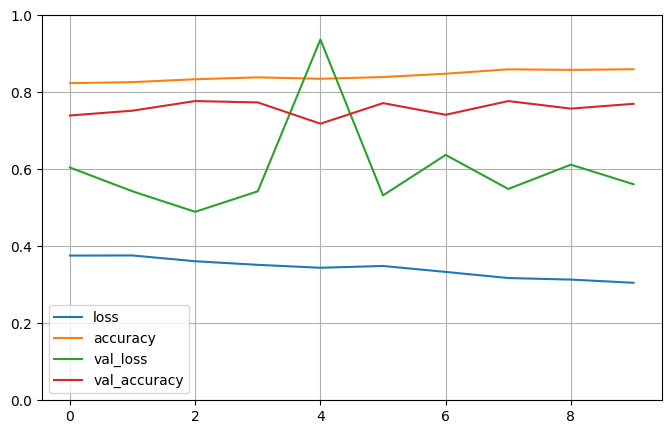

In [231]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

## D. Optimisation des hyperparamètres

J'ai pas executé entièrement car cela prend beaucoup trop de temps pour être exécuté sur une machine classique. Même en diminuant au maximum les paramètres cela prendrait plusieurs heures.

In [238]:
def build_model(hp):
    model = Sequential()
    # Ajout d'une couche Conv2D avec un nombre d'unités ajustable via hyperparamètres
    model.add(Conv2D(
        hp.Int('input_units', min_value=32, max_value=256, step=32), 
        (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(2, 2))  # Couche de MaxPooling
    model.add(Flatten())  # Aplatir les données pour les couches denses
    # Ajout d'une couche Dense avec un nombre d'unités ajustable
    model.add(Dense(
        hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Couche de sortie pour classification binaire

    # Compilation du modèle avec un taux d'apprentissage ajustable et autres paramètres fixes
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

# Configuration de l'optimiseur d'hyperparamètres
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # Objectif : maximiser la précision de validation
    max_trials=10,  # Nombre maximal de configurations à tester
    executions_per_trial=1,  # Exécutions par essai
    directory='my_dir',  # Dossier pour enregistrer les résultats
    project_name='hparam_tuning'  # Nom du projet
)

# Recherche des meilleurs hyperparamètres
tuner.search(
    train_generator,  # Générateur de données d'entraînement
    epochs=10,  # Nombre d'époques pour chaque essai
    validation_data=validation_generator  # Données de validation
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
160               |160               |input_units
64                |64                |dense_units
0.0093098         |0.0093098         |learning_rate



KeyboardInterrupt: 

## E. Modèle SVM

Contrairement aux modèles CNN, le SVM ne permet pas d'analyser directement les images, il faut donc d'abord effectuer une étape d'extraction de caractéristiques. Cette étape consiste à transformer les données d'image, qui sont généralement de haute dimensionnalité, en un format adapté pour le SVM.

De la même façon que pour les modèles CNN, le temps de calcul est trop important pour effectué un grid_search avec une machine classique avec ces données.

### i. Prétraitement

In [261]:
def extract_features_labels(generator):
    features, labels = [], []
    for _ in range(len(generator)):
        x, y = next(generator)
        features.append(x)
        labels.append(y)
    return np.vstack(features), np.hstack(labels)

# Extraction des caractéristiques et des étiquettes
train_features, train_labels = extract_features_labels(train_generator)
validation_features, validation_labels = extract_features_labels(validation_generator)

# Aplatir les caractéristiques pour le SVM
train_features_flat = train_features.reshape((train_features.shape[0], -1))
validation_features_flat = validation_features.reshape((validation_features.shape[0], -1))

C:\Users\theob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


In [262]:
print("Classes dans l'ensemble d'entraînement:", np.unique(train_labels))
print("Classes dans l'ensemble de validation:", np.unique(validation_labels))

Classes dans l'ensemble d'entraînement: [0. 1.]
Classes dans l'ensemble de validation: [0. 1.]


### ii. Entrainement & prédiction

In [263]:
# Création d'un pipeline avec normalisation et SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1, gamma='auto'))
])

# Entraînement du modèle SVM
svm_pipeline.fit(train_features_flat, train_labels)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=1, gamma='auto'))])

In [264]:
# Prédiction sur l'ensemble de validation
validation_predictions = svm_pipeline.predict(validation_features_flat)

# Rapport de classification
print("Précision sur l'ensemble de validation:", accuracy_score(validation_labels, validation_predictions))
print(classification_report(validation_labels, validation_predictions))

Précision sur l'ensemble de validation: 0.7379679144385026
              precision    recall  f1-score   support

         0.0       0.66      0.58      0.61       203
         1.0       0.78      0.83      0.80       358

    accuracy                           0.74       561
   macro avg       0.72      0.70      0.71       561
weighted avg       0.73      0.74      0.73       561

